# 0. Modules imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
from scipy.spatial import distance
import math
import random as rd



# 1. Main functions and objects definition

In [2]:
def damped_sine(m, A, k, f, phi):
    return A * np.exp(-k * m) * np.cos(2 * np.pi * f * m + phi)

In [3]:
def autocorrelation(x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]
    return gammax,lags

In [4]:
def dtw(x,y,w=np.Inf):    
    Nx=np.size(x)
    Ny=np.size(y)
    x_=np.reshape(x,(Nx,1))
    y_=np.reshape(y,(Ny,1))
    # Computation of the distance matrix
    D=distance.cdist(x_, y_, 'euclidean')**2
    # Computation of the cumulative distance matrix
    C=np.Inf*np.ones((Nx+1,Ny+1))
    C[0,0]=0    
    for i in range(1,Nx+1):
        for j in range(int(np.maximum(1,i-w)),int(np.minimum(Ny+1,i+w+1))):
            C[i,j] = D[i-1,j-1] + np.amin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
    # Computation of the path
    path=[[Nx-1,Ny-1]]
    i=Nx-1
    j=Ny-1
    while i>0 and j>0:
        ind=np.argmin([C[i-1,j-1],C[i-1,j],C[i,j-1]])
        if ind==0:
            path = np.insert(path, 0, [i-1, j-1], axis=0)
            i-=1
            j-=1
        elif ind==1:
            path = np.insert(path, 0, [i-1, j], axis=0)
            i-=1
        elif ind==2:
            path=np.insert(path, 0, [i, j-1], axis=0)
            j-=1
        
    return np.sqrt(C[Nx,Ny]),path

In [5]:
def fit_autocorrelation(data,
        p0 = [1, 0.01, 0.05, 0],
        model = damped_sine,
        maxLags = 100):

    try:
        gammax, lags = autocorrelation(data.values, maxLags)
        positive_lags = lags[lags >= 0]
        autocorr = gammax[lags >= 0]
        lags_fit = positive_lags[1:]
        autocorr_fit = autocorr[1:]
        popt, _ = curve_fit(damped_sine, lags_fit, autocorr_fit, p0=p0, maxfev =10000)
        A_fitted, k_fitted, f_fitted, phi_fitted = popt

    except RuntimeError:
        popt = p0

    autocorr_fitted = damped_sine(positive_lags, *popt)
    reconstruction_error,_ = dtw(autocorr_fit, autocorr_fitted)

    return A_fitted, k_fitted, f_fitted, phi_fitted, reconstruction_error


In [6]:
class Data():
    def __init__(self, index, values,  database_name = ''):
        self.index = index
        self.database_name = database_name

        #Forbidden info in the context of the project
        #self.class_index = values[0]

        self.values = np.array(values[1:])

        self.A_fitted, self.k_fitted, self.f_fitted, self.phi_fitted, self.reconstruction_error = fit_autocorrelation(self)



In [7]:
class Database():
    def __init__(self, name, datas):
        self.name = name
        self.datas = datas

        for data in self.datas:
            data.database_name = self.name

# 2. Database loading

In [8]:
def load_database(database_path):
    datas = []

    with open(database_path, 'r') as file:
        data_index = 0
        for raw_data in file:
            raw_data_line = raw_data.strip('\n').split(' ')
            data_values = []
            for raw_value in raw_data_line:
                if len(raw_value)!=0:
                    data_values.append(float(raw_value))

            datas.append(Data(data_index, data_values))
            data_index += 1
        
    name = database_path.strip('.txt').split('/')[-1]
    return Database(name, datas)

In [9]:
train_database_path = '/teamspace/studios/this_studio/Données/FordB_TRAIN.txt'
test_database_path = '/teamspace/studios/this_studio/Données/FordB_TEST.txt'

In [10]:
train_database = load_database(train_database_path)
test_database = load_database(test_database_path)

# 3. Visualisation of the fitted parameters of the autocorrelation-profile model distribution 

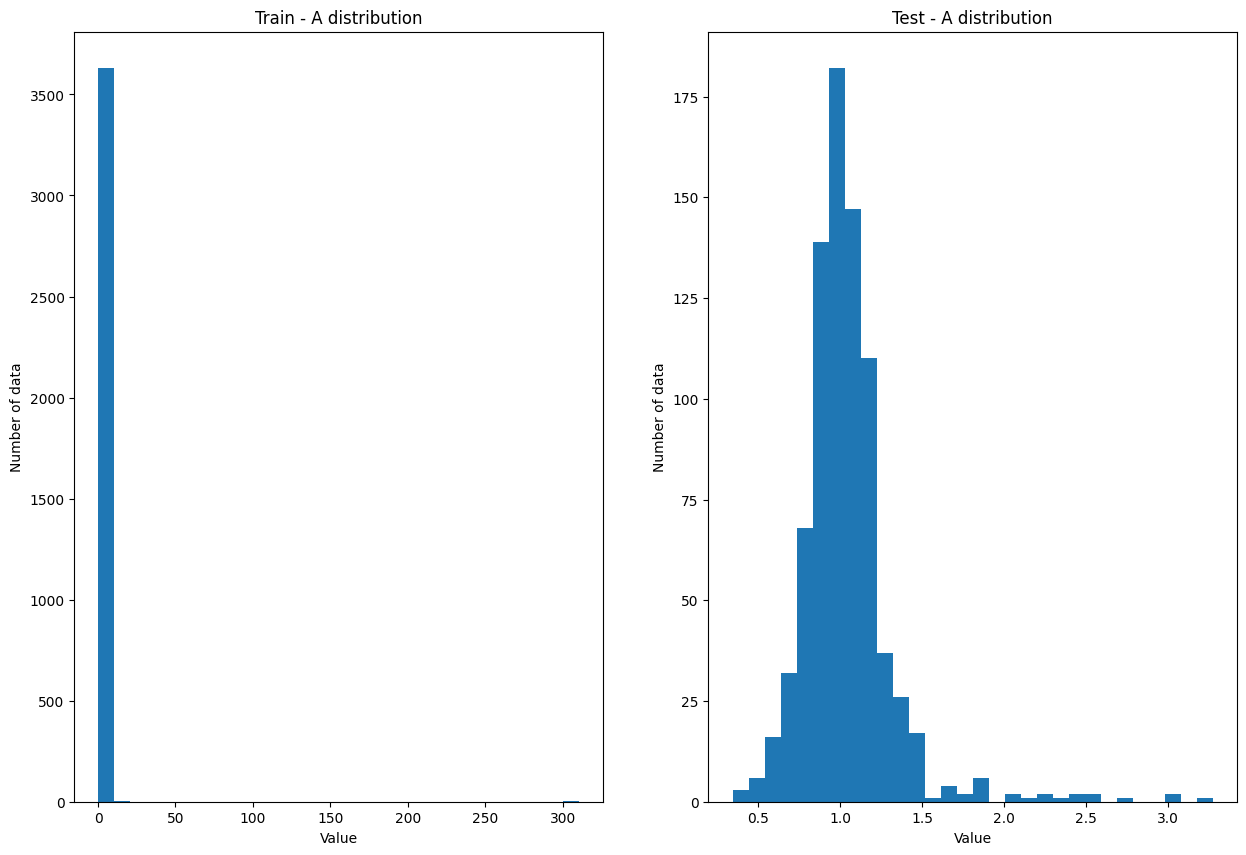

In [11]:
train_A = [data.A_fitted for data in train_database.datas]
test_A = [data.A_fitted for data in test_database.datas]

cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

axes[0].hist(train_A, bins = 30)
axes[0].set_title(f'Train - A distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

axes[1].hist(test_A, bins = 30)
axes[1].set_title(f'Test - A distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()

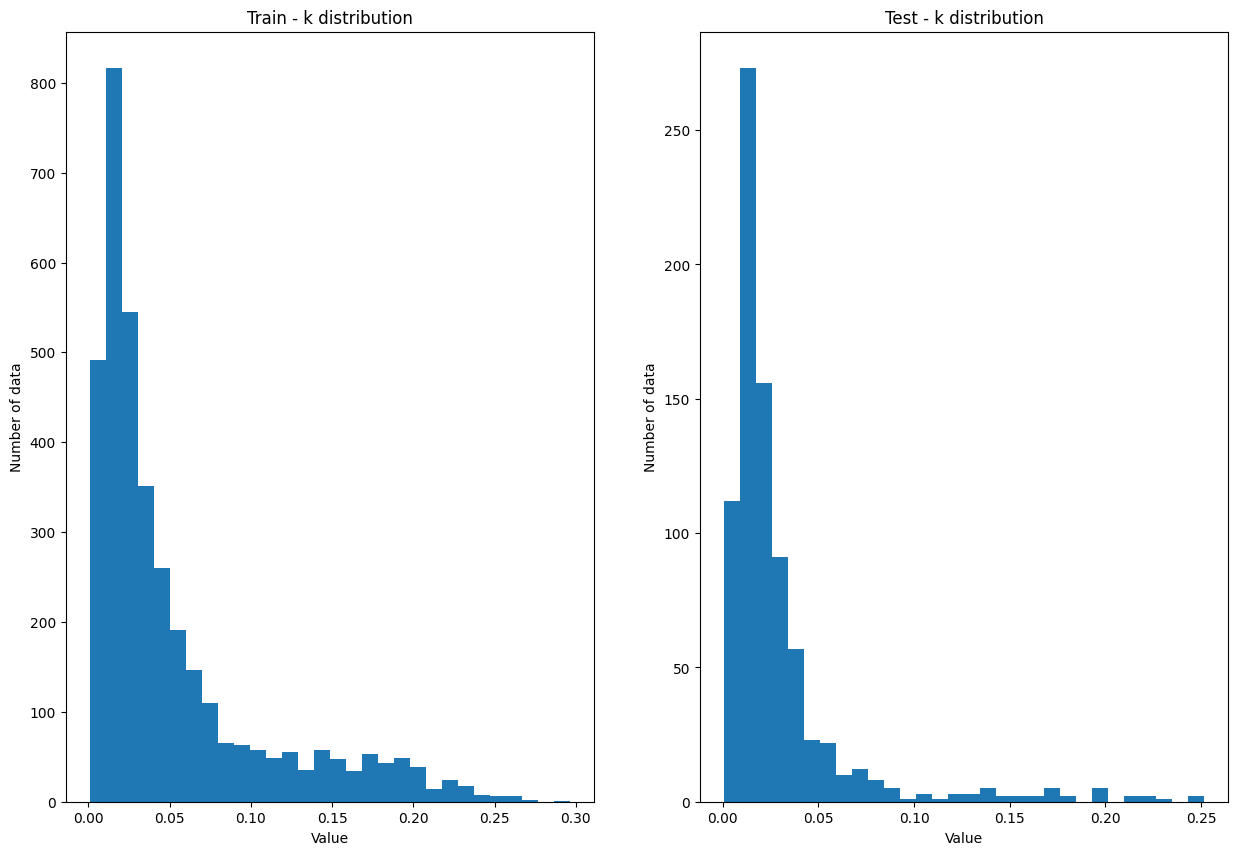

In [12]:
train_k_fitted = [data.k_fitted for data in train_database.datas]
test_k_fitted = [data.k_fitted for data in test_database.datas]

cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

axes[0].hist(train_k_fitted, bins = 30)
axes[0].set_title(f'Train - k distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

axes[1].hist(test_k_fitted, bins = 30)
axes[1].set_title(f'Test - k distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()

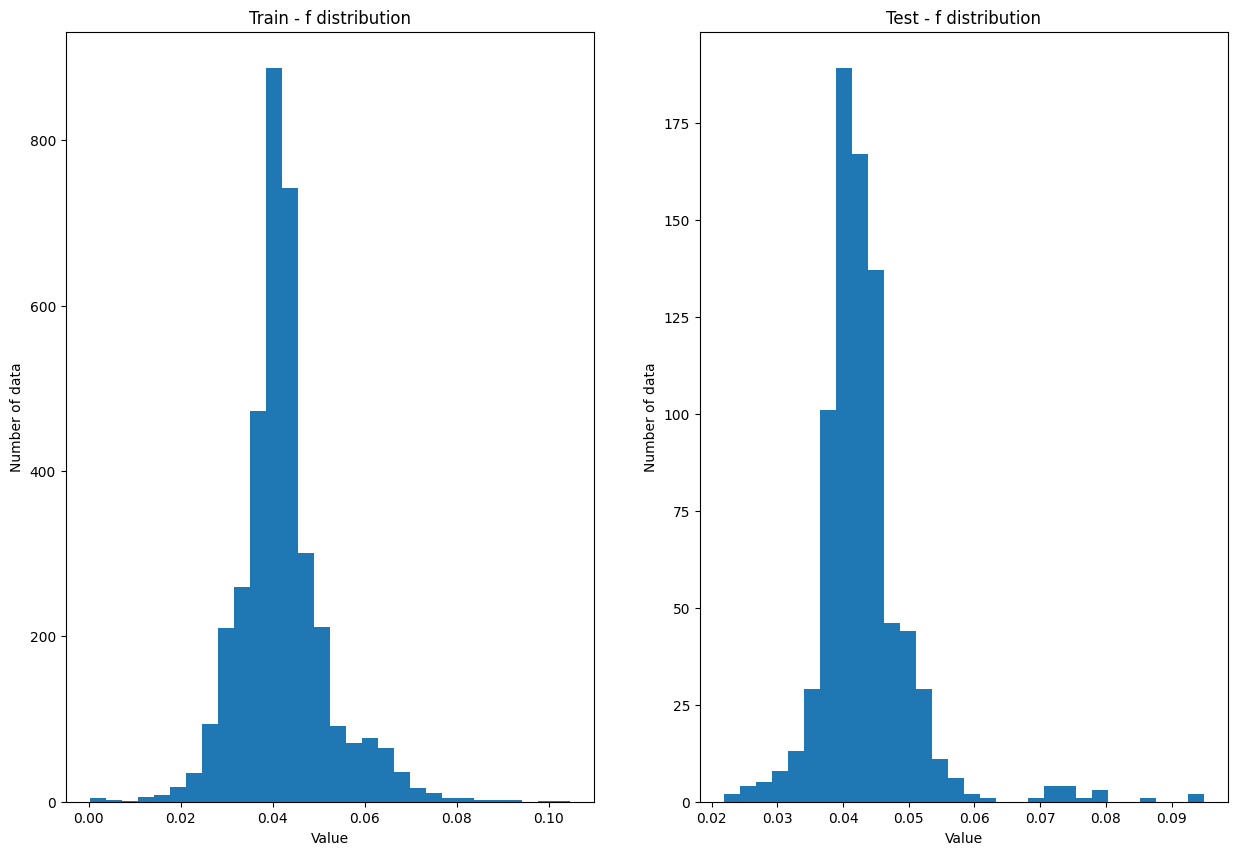

In [13]:
train_f_fitted = [data.f_fitted for data in train_database.datas]
test_f_fitted = [data.f_fitted for data in test_database.datas]

cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

axes[0].hist(train_f_fitted, bins = 30)
axes[0].set_title(f'Train - f distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

axes[1].hist(test_f_fitted, bins = 30)
axes[1].set_title(f'Test - f distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()

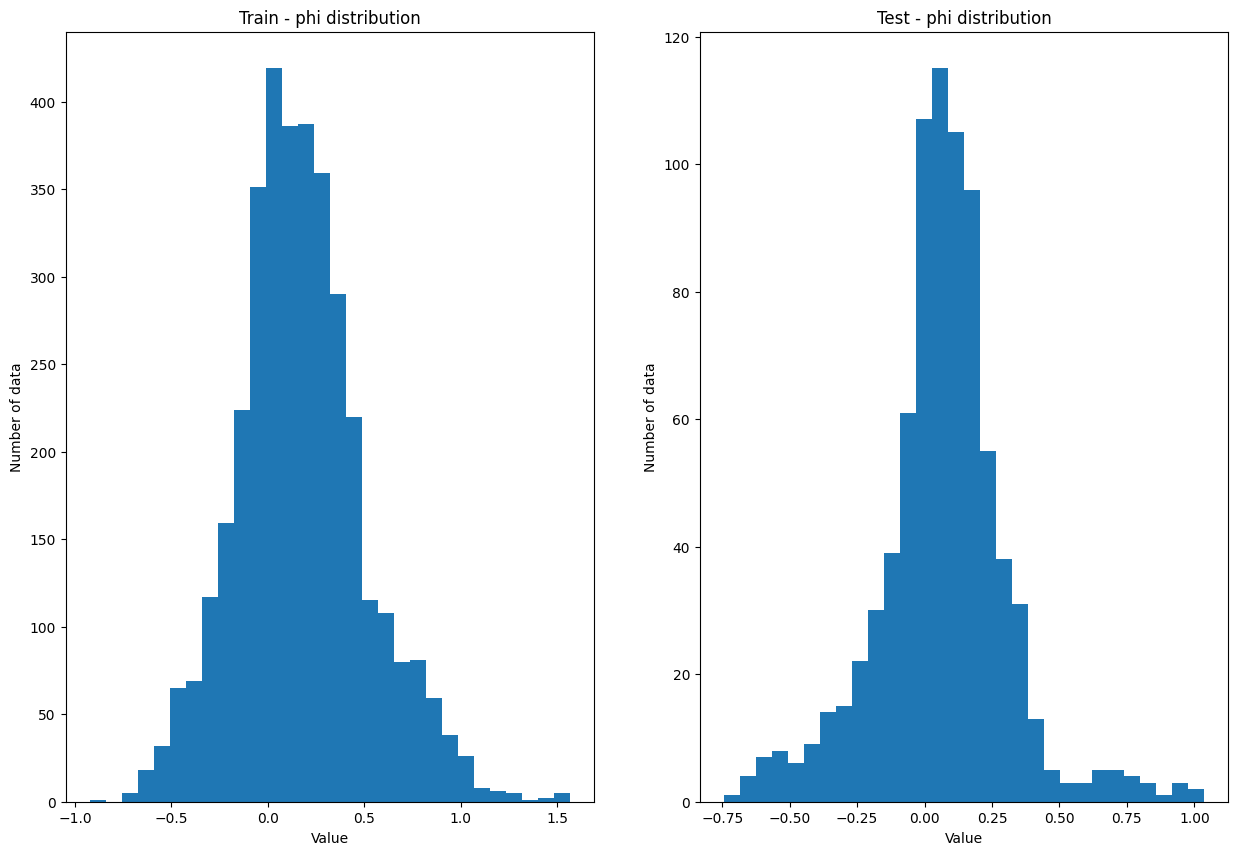

In [14]:
train_phi_fitted = [data.phi_fitted for data in train_database.datas]
test_phi_fitted = [data.phi_fitted for data in test_database.datas]

cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

axes[0].hist(train_phi_fitted, bins = 30)
axes[0].set_title(f'Train - phi distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

axes[1].hist(test_phi_fitted, bins = 30)
axes[1].set_title(f'Test - phi distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()

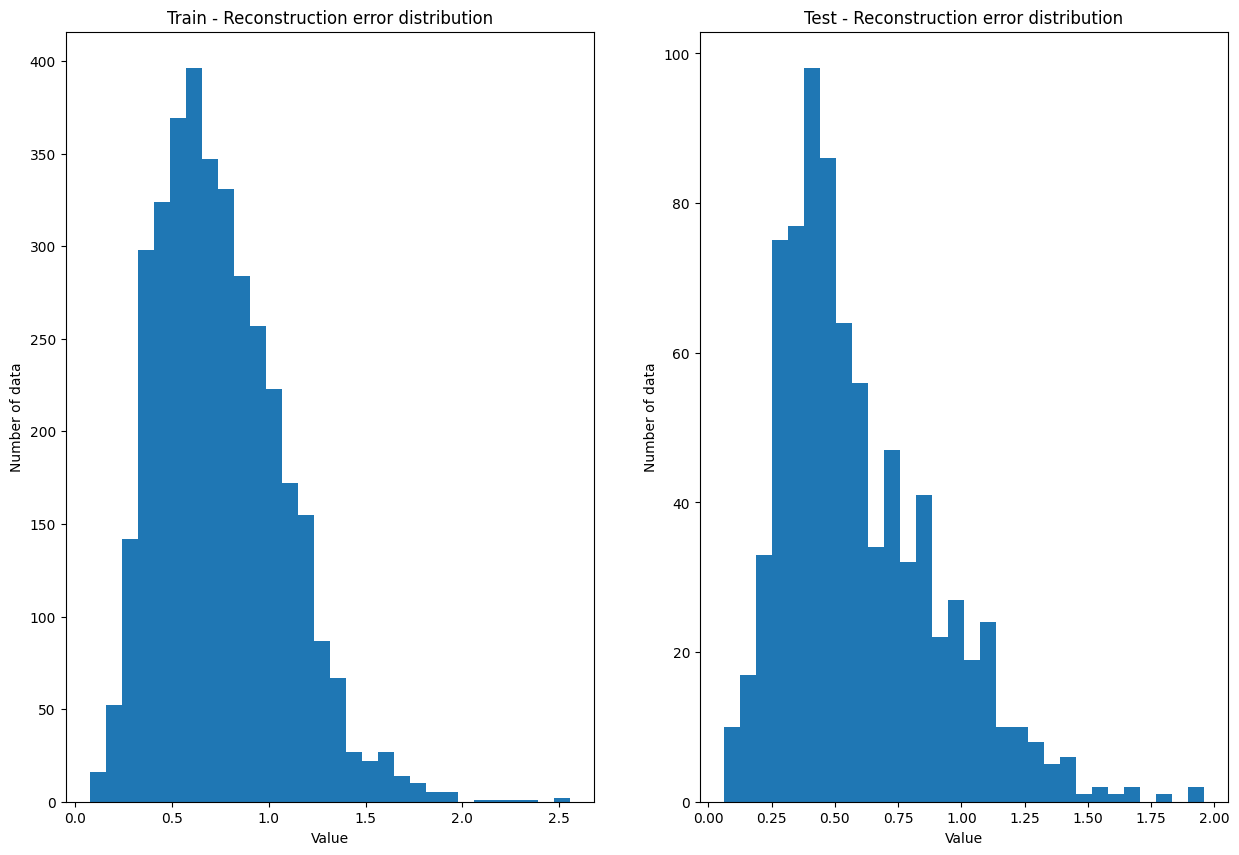

In [15]:
train_reconstruction_error = [data.reconstruction_error for data in train_database.datas]
test_reconstruction_error = [data.reconstruction_error for data in test_database.datas]

cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

axes[0].hist(train_reconstruction_error, bins = 30)
axes[0].set_title(f'Train - Reconstruction error distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

axes[1].hist(test_reconstruction_error, bins = 30)
axes[1].set_title(f'Test - Reconstruction error distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()

# 4. Plotting some autocorrelation profiles

In [49]:
def plot_autocorrelation_visualisation(data, axis = None, maxLags = 100):
    autocorrelation_real, lags = autocorrelation(data.values, maxLags)
    autocorrelation_real = autocorrelation_real[lags > 0]
    lags = lags[lags > 0]

    autocorrelation_model = damped_sine(lags, data.A_fitted, data.k_fitted, data.f_fitted, data.phi_fitted)

    if axis != None:
        axis.plot(lags, autocorrelation_real, linestyle='-', color='blue', label='Autocorrélation')
        axis.plot(lags, autocorrelation_model, linestyle='--', color='red', label='Modèle ajusté')
        axis.legend()
        axis.set_title(f'Autocorrélation - {data.database_name} {data.index}')
        axis.text(0.05, 0.95, f'A={data.A_fitted:.2f}\nk={data.k_fitted:.2f}\nf={data.f_fitted:.2f}\nphi={data.phi_fitted:.2f}\nDTW={data.reconstruction_error:.2f}',
                transform=axis.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        axis.set_ylabel('$\hat{{\gamma}}_x[m]$')
        axis.set_xlabel('Décalage $m$')
        axis.grid(True)
        return axis
    
    plt.plot(lags, autocorrelation_real, linestyle='-', color='blue', label='Autocorrélation')
    plt.plot(lags, autocorrelation_model, linestyle='--', color='red', label='Modèle ajusté')
    plt.legend()
    plt.title(f'Autocorrélation - {data.database_name} {data.index}')
    plt.text(0.05, 0.95, f'A={data.A_fitted:.2f}\nk={data.k_fitted:.2f}\nf={data.f_fitted:.2f}\nphi={data.phi_fitted:.2f}\nDTW={data.reconstruction_error:.2f}',
            transform=axis.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.ylabel('$\hat{{\gamma}}_x[m]$')
    plt.xlabel('Décalage $m$')
    plt.grid(True)

In [50]:
sample_size = 12
train_sample = rd.sample(train_database.datas, sample_size)
test_sample = rd.sample(test_database.datas, sample_size)

<Figure size 640x480 with 0 Axes>

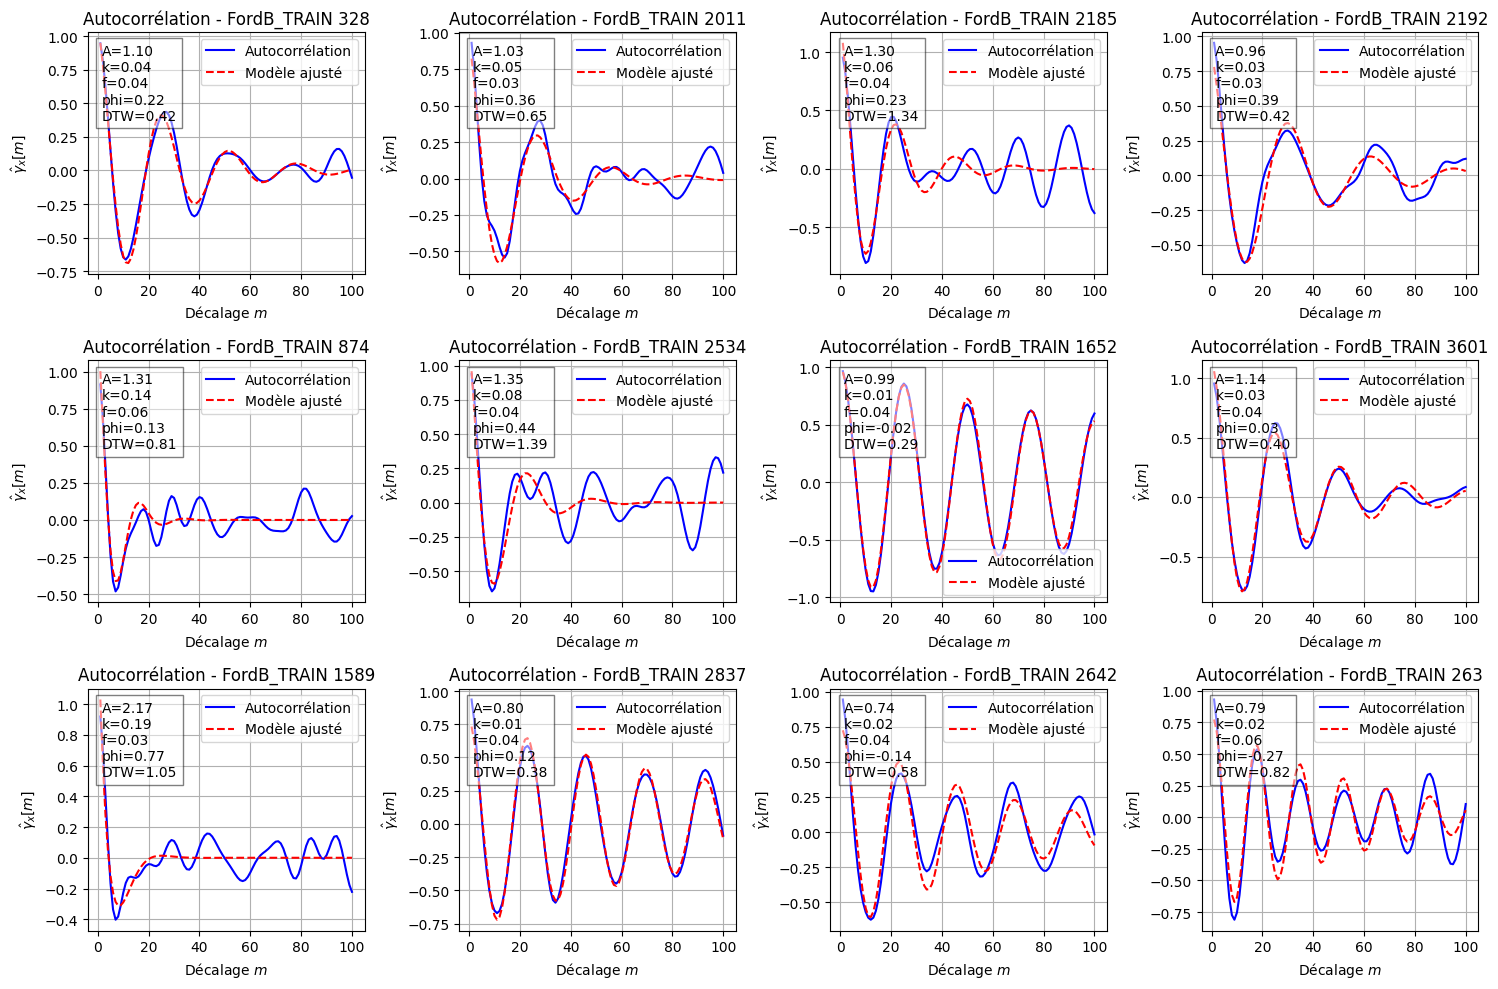

In [51]:
plt.clf()

# Calculate number of rows and columns (can be square or based on your preference)
cols = math.ceil(math.sqrt(len(train_sample)))  # Try to make the figure roughly square
rows = math.ceil(len(train_sample) / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

# Now plot something on each subplot
for  i, data in enumerate(train_sample):
    plot_autocorrelation_visualisation(data, axis = axes[i])


# Hide unused subplots if any
for i in range(len(train_sample), rows * cols):
    fig.delaxes(axes[i])  # Deletes the extra subplots

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

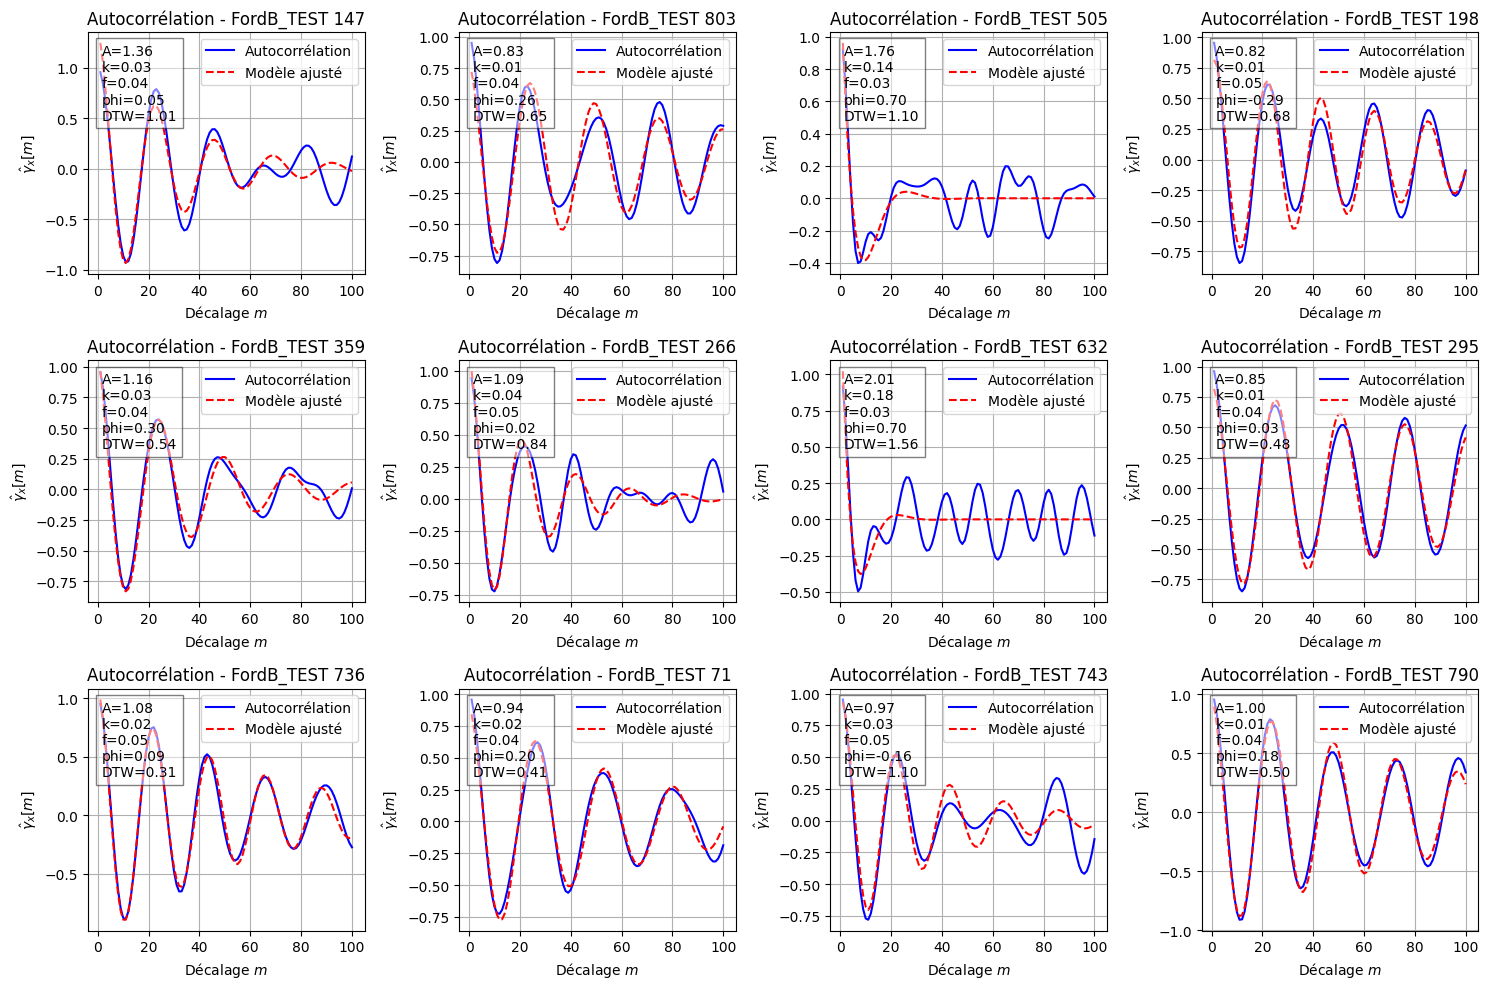

In [52]:
plt.clf()

# Calculate number of rows and columns (can be square or based on your preference)
cols = math.ceil(math.sqrt(len(test_sample)))  # Try to make the figure roughly square
rows = math.ceil(len(test_sample) / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

# Now plot something on each subplot
for  i, data in enumerate(test_sample):
    plot_autocorrelation_visualisation(data, axis = axes[i])


# Hide unused subplots if any
for i in range(len(test_sample), rows * cols):
    fig.delaxes(axes[i])  # Deletes the extra subplots

plt.tight_layout()
plt.show()